# Chatbot with Memory

## Review

[Memory](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/) is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

There are [various long-term memory types](https://langchain-ai.github.io/langgraph/concepts/memory/#memory) that can be used in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

We'll focus on long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory), which will be facts about the user.

These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

It will save memory ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

%%capture --no-stderr
%pip install -U langchain_google_genai langgraph langchain_core

## Introduction to the LangGraph Store

The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

When storing objects (e.g., memories) in the [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [4]:
import uuid
from langgraph.store.memory import InMemoryStore
memory_store = InMemoryStore()
user_id = '1'
session_id = str(uuid.uuid4())
name_space = (user_id,'memory_agent')

In [6]:
print(f'user_id: {user_id}')
print(f'session_id: {session_id}')
print(f'name_space:{name_space}')

user_id: 1
session_id: 871b94ae-09f4-4e74-b2c8-14d3286e80e9
name_space:('1', 'memory_agent')


In [7]:
value = {'name':'Arman','age':23,'profile':'I have completed Bachelor\'s degree in Mathematics. Now i want to learn Agentic AI'}
memory_store.put(name_space,session_id,value)

In [8]:
session_id = str(uuid.uuid4())
value = {'name':'Arman','age':23,'profile':'I have completed Bachelor\'s degree in Mathematics. Now i want to learn Agentic AI','teacher':'My best teacher is Sir Zia Khan'}
memory_store.put(name_space,session_id,value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by `namespace`.

This returns a list.

In [9]:
search_memory = memory_store.search(name_space)
print(search_memory)

[Item(namespace=['1', 'memory_agent'], key='871b94ae-09f4-4e74-b2c8-14d3286e80e9', value={'name': 'Arman', 'age': 23, 'profile': "I have completed Bachelor's degree in Mathematics. Now i want to learn Agentic AI"}, created_at='2025-02-17T07:37:48.179092+00:00', updated_at='2025-02-17T07:37:48.179092+00:00', score=None), Item(namespace=['1', 'memory_agent'], key='945e94b4-9684-4161-967b-1d3521dd726d', value={'name': 'Arman', 'age': 23, 'profile': "I have completed Bachelor's degree in Mathematics. Now i want to learn Agentic AI", 'teacher': 'My best teacher is Sir Zia Khan'}, created_at='2025-02-17T07:37:49.328436+00:00', updated_at='2025-02-17T07:37:49.328436+00:00', score=None)]


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [10]:
get_memory = memory_store.get(name_space,'9697e0cd-92b3-47f6-9159-7a63019952a1')
print(get_memory)

None


## Chatbot with long-term memory

We want a chatbot that [has two types of memory](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156):

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

In [11]:
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")

print("API key loaded from .env file.")

API key loaded from .env file.


For `short-term memory`, we'll use a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).

See Module 2 and our [conceptual docs](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more on checkpointers, but in summary:

* They write the graph state at each step to a thread.
* They persist the chat history in the thread.
* They allow the graph to be interrupted and / or resumed from any step in the thread.

And, for `long-term memory`, we'll use the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as introduced above.

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=GEMINI_API_KEY)

The chat history will be saved to short-term memory using the checkpointer.

The chatbot will reflect on the chat history.

It will then create and save a memory to the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore).

This memory is accessible in future chat sessions to personalize the chatbot's responses.

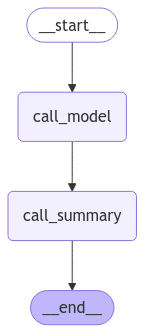

In [13]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""
def call_model(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory')
  if existing_memory:
     existing_memory_content = existing_memory.value.get('memory')
  else:
    existing_memory_content = "No existing memory found."
  sys_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
 
  messages = [SystemMessage(content=sys_msg)] + state["messages"]

  resp = model.invoke(messages)
  return {"messages":resp}



CREATE_MEMORY_INSTRUCTION = """"You are collecting information about
the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""
def call_summary(state:MessagesState,config:RunnableConfig,store:BaseStore):
  user_id = config["configurable"]["user_id"]
  namespace = ("memory", user_id) 
  existing_memory = store.get(namespace, 'user_memory')
  if existing_memory:
     existing_memory_content = existing_memory.value.get('memory')
  else:
    existing_memory_content = "No existing memory found."
  sys_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
  messages = [SystemMessage(content=sys_msg) ]+ state["messages"]
  resp = model.invoke(messages)  
  store.put(namespace, 'user_memory', {"memory": resp.content})



graph = StateGraph(MessagesState)
graph.add_node('call_model',call_model)
graph.add_node('call_summary',call_summary)

graph.add_edge(START,'call_model') 
graph.add_edge('call_model','call_summary')
graph.add_edge('call_summary',END)

short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()
compiled_graph = graph.compile(checkpointer=short_term_memory,store=long_term_memory) 

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice.

In [14]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="Hi, my name is arman")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, my name is arman
================================== Ai Message ==================================

Hello Arman, it's nice to meet you!  I'll remember that for our future conversations.


In [15]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} 
input_messages = [HumanMessage(content="I like programming")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like programming
================================== Ai Message ==================================

That's great, Arman!  Programming is a fascinating and rewarding field. What kind of programming are you interested in?  Do you have a favorite language or area of focus (e.g., web development, game development, data science)?


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [16]:

thread = {"configurable": {"thread_id": "1"}}
state = compiled_graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is arman
================================== Ai Message ==================================

Hello Arman, it's nice to meet you!  I'll remember that for our future conversations.
================================ Human Message =================================

I like programming
================================== Ai Message ==================================

That's great, Arman!  Programming is a fascinating and rewarding field. What kind of programming are you interested in?  Do you have a favorite language or area of focus (e.g., web development, game development, data science)?


Recall that we compiled the graph with our the store:

```python
across_thread_memory = InMemoryStore()
```

And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [17]:
user_id = "1"
namespace = ("memory", user_id)
get_memory = long_term_memory.get(namespace,'user_memory')
if get_memory is not None:
    print(get_memory.dict())   
else:
    print("No memory found for this user.")

{'namespace': ['memory', '1'], 'key': 'user_memory', 'value': {'memory': "Here's an updated summary of what I know about you:\n\n* Name: Arman\n* Likes: Programming\n\n"}, 'created_at': '2025-02-17T07:38:05.931736+00:00', 'updated_at': '2025-02-17T07:38:05.931736+00:00'}


In [18]:

user_id = "12"
namespace = ("memory", user_id)
get_memory = long_term_memory.get(namespace,'user_memory')
if get_memory is not None:
    print(get_memory.dict())   
else:
    print("No memory found for this user.")

No memory found for this user.


Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [19]:
config = {"configurable": {"thread_id": "12", "user_id": "1"}} 
input_messages = [HumanMessage(content="Hi! What do you know about me?")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! What do you know about me?
================================== Ai Message ==================================

Hi Arman!  I know that you like programming.  Is there anything else I should know about you?


In [20]:
 
input_messages = [HumanMessage(content="I am from pakistan")] 
for chunk in compiled_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I am from pakistan
================================== Ai Message ==================================

That's great to know, Arman!  So you're a programmer from Pakistan.  Is there anything else you'd like to share, or any questions you have for me?


In [21]:
user_id = "1"
namespace = ("memory", user_id)
get_memory = long_term_memory.get(namespace,'user_memory')
if get_memory is not None:
    print(get_memory.dict())   
else:
    print("No memory found for this user.")

{'namespace': ['memory', '1'], 'key': 'user_memory', 'value': {'memory': "Here's my updated information about you:\n\n* Name: Arman\n* Likes: Programming\n* Location: Pakistan\n"}, 'created_at': '2025-02-17T07:38:27.245643+00:00', 'updated_at': '2025-02-17T07:38:27.245643+00:00'}


## Viewing traces in LangSmith

We can see that the memories are retrieved from the store and supplied as part of the system prompt, as expected:

https://smith.langchain.com/public/10268d64-82ff-434e-ac02-4afa5cc15432/r